In [79]:
# Import Libraries yang diperlukan
import pandas as pd #manipulasi data
import numpy as np #operasi matematika dan array
import matplotlib.pyplot as plt #visualisasi grafik
import seaborn as sns 
from sklearn.model_selection import train_test_split #memecah dataset menjadi training dan testing
from sklearn.preprocessing import StandardScaler #normalisasi data
from sklearn.ensemble import RandomForestClassifier #algoritma Random Forest Classifier
from sklearn.linear_model import LogisticRegression #algoritma Logistic Regression
from sklearn.svm import SVC #algoritma Support Vector Machine (SVM)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #evaluasi model
from sklearn.metrics import roc_curve, auc, roc_auc_score #evaluasi model
import warnings 
warnings.filterwarnings('ignore') #menghilangkan peringatan

# Tahap 1: Business Understanding

## Menentukan Label Data dan Tujuan Bisnis
- **Target Variable**: Outcome (0 = Tidak Diabetes, 1 = Diabetes)
- **Tujuan**: Memprediksi kemungkinan seseorang terkena diabetes berdasarkan faktor-faktor kesehatan
- **Manfaat**: Deteksi dini diabetes untuk pencegahan dan pengobatan yang lebih baik

# Tahap 2: Data Understanding

## a) Mengumpulkan Data

In [80]:
# Memuat dataset diabetes
df = pd.read_csv('diabetes.csv')

# Menampilkan 5 data pertama
display(df.head())
# Menampilkan statistik
display(df.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## b) Mengidentifikasi Data

In [ ]:
# Mengidentifikasi fitur-fitur dalam dataset
feature_descriptions = {
    'Pregnancies': 'Jumlah kehamilan',
    'Glucose': 'Kadar Gula Darah (mg/dL)',
    'BloodPressure': 'Tekanan darah (mm Hg)',
    'SkinThickness': 'Ketebalan kulit triceps (lengan belakang atas) (mm)',
    'Insulin': 'Insulin (mu U/ml)',
    'BMI': 'Body Mass Index (kg/m²)',
    'DiabetesPedigreeFunction': 'Riwayat Diabetes keluarga',
    'Age': 'Usia (tahun)',
    'Outcome': 'Target - 0: Tidak diabetes, 1: Diabetes'
}

for feature, description in feature_descriptions.items():
    f"• {feature}: {description}"

# Analisis distribusi target variable
outcome_counts = df['Outcome'].value_counts()
outcome_percentage = df['Outcome'].value_counts(normalize=True) * 100 #dalam bentuk persen

print(f"Tidak Diabetes (0): {outcome_counts[0]} ({outcome_percentage[0]:.1f}%)")
print(f"Diabetes (1): {outcome_counts[1]} ({outcome_percentage[1]:.1f}%)")


Tidak Diabetes (0): 500 (65.1%)
Diabetes (1): 268 (34.9%)


## c) Visalisasi Grafik

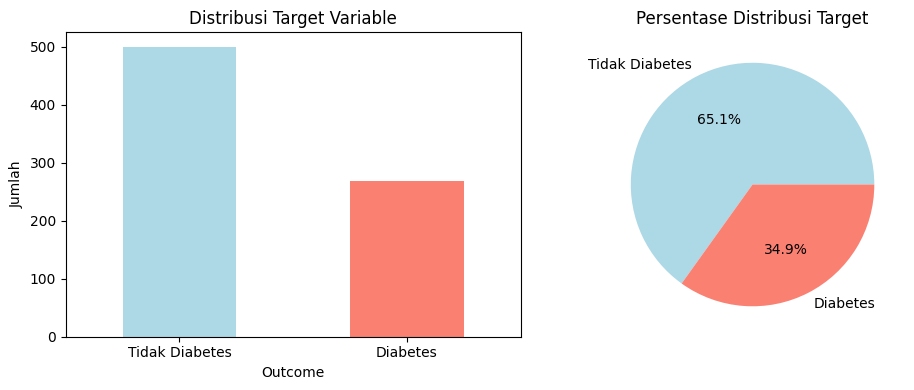

In [82]:
# Visualisasi distribusi target
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
outcome_counts.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Distribusi Target Variable')
plt.xlabel('Outcome')
plt.ylabel('Jumlah')
plt.xticks([0, 1], ['Tidak Diabetes', 'Diabetes'], rotation=0)

plt.subplot(1, 2, 2)
plt.pie(outcome_counts.values, labels=['Tidak Diabetes', 'Diabetes'], 
        autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Persentase Distribusi Target')

plt.tight_layout()
plt.show()

## d) Memvalidasi Data

In [ ]:
# 1. Cek missing values Awal
missing_values = df.isnull().sum()
(missing_values)
# Tidak ada nilai NaN

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [84]:
# 2. Cek nilai 0 yang tidak masuk akal (khusus untuk fitur tertentu)
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in zero_columns:
    zero_count = (df[col] == 0).sum()
    zero_percentage = (zero_count / len(df)) * 100
    print(f"{col}: {zero_count} nilai 0 ({zero_percentage:.1f}%)")

Glucose: 5 nilai 0 (0.7%)
BloodPressure: 35 nilai 0 (4.6%)
SkinThickness: 227 nilai 0 (29.6%)
Insulin: 374 nilai 0 (48.7%)
BMI: 11 nilai 0 (1.4%)


In [85]:
# 3. Deteksi outliers menggunakan IQR (Interqueartile Range)
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    # Batas Outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers)

# Mendeteksi jumlah outliers pada setiap kolom numerik
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if col != 'Outcome':
        outlier_count = detect_outliers_iqr(df, col)
        outlier_percentage = (outlier_count / len(df)) * 100
        print(f"{col}: {outlier_count} outliers ({outlier_percentage:.1f}%)")

Pregnancies: 4 outliers (0.5%)
Glucose: 5 outliers (0.7%)
BloodPressure: 45 outliers (5.9%)
SkinThickness: 1 outliers (0.1%)
Insulin: 34 outliers (4.4%)
BMI: 19 outliers (2.5%)
DiabetesPedigreeFunction: 29 outliers (3.8%)
Age: 9 outliers (1.2%)


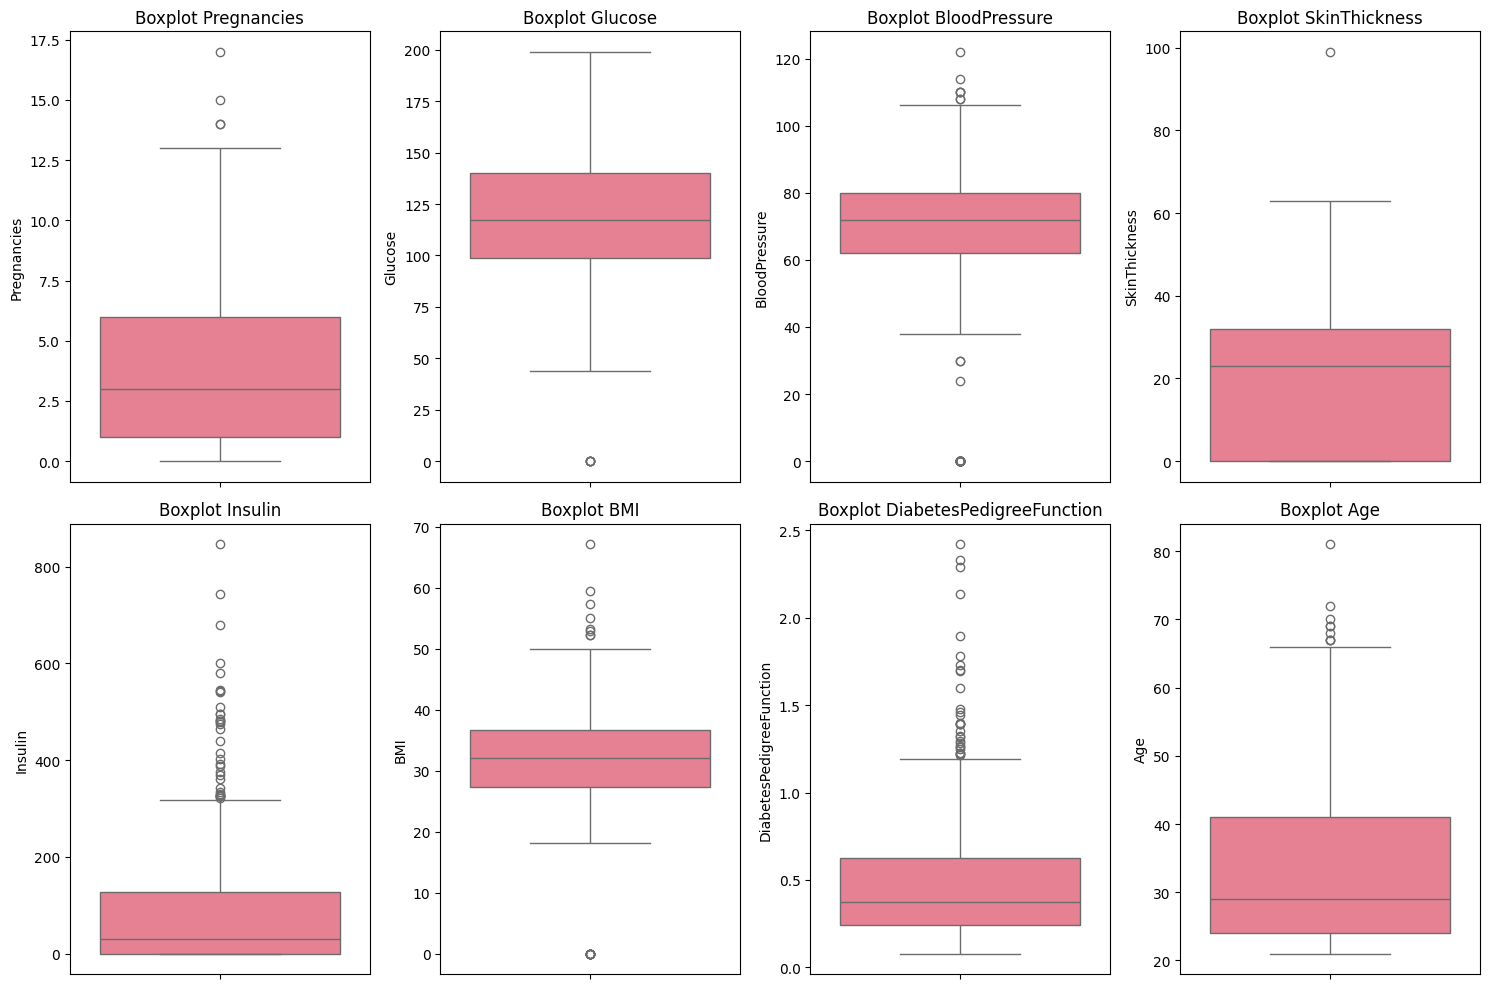

In [86]:
# 4. Visualisasi boxplot untuk melihat outliers
plt.figure(figsize=(15, 10))
numeric_cols = [col for col in numeric_columns if col != 'Outcome']

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Tahap 3: Data Preparation

## Menentukan Objek Data, Membersihkan Data, dan Mengkonstruksi Data

In [87]:
# Membuat copy dataset untuk preprocessing
df_cleaned = df.copy()
df.shape

(768, 9)

## a) Imputasi nilai 0 anomaly dengan median

In [88]:
# 1. Menangani nilai 0 yang tidak normal dengan median
# Kolom yang tidak boleh bernilai 0 secara medis
columns_to_replace_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns_to_replace_zero:
    # Hitung median dari nilai non-zero
    median_value = df_cleaned[df_cleaned[col] != 0][col].median()
    
    # Ganti nilai 0 dengan median
    zero_count_before = (df_cleaned[col] == 0).sum()
    df_cleaned[col] = df_cleaned[col].replace(0, median_value)
    
    print(f"• {col}: {zero_count_before} nilai 0 diganti dengan median = {median_value:.2f}")

print(f"\n✅ Dataset setelah pembersihan: {df_cleaned.shape}")

• Glucose: 5 nilai 0 diganti dengan median = 117.00
• BloodPressure: 35 nilai 0 diganti dengan median = 72.00
• SkinThickness: 227 nilai 0 diganti dengan median = 29.00
• Insulin: 374 nilai 0 diganti dengan median = 125.00
• BMI: 11 nilai 0 diganti dengan median = 32.30

✅ Dataset setelah pembersihan: (768, 9)


In [89]:
# 2. Cek hasil pembersihan
for col in columns_to_replace_zero:
    zero_count_after = (df_cleaned[col] == 0).sum()
    print(f"• {col}: {zero_count_after} nilai 0 tersisa")

• Glucose: 0 nilai 0 tersisa
• BloodPressure: 0 nilai 0 tersisa
• SkinThickness: 0 nilai 0 tersisa
• Insulin: 0 nilai 0 tersisa
• BMI: 0 nilai 0 tersisa


In [90]:
# 3. Menampilkan statistik setelah pembersihan
display(df_cleaned.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## b) Cek EDA

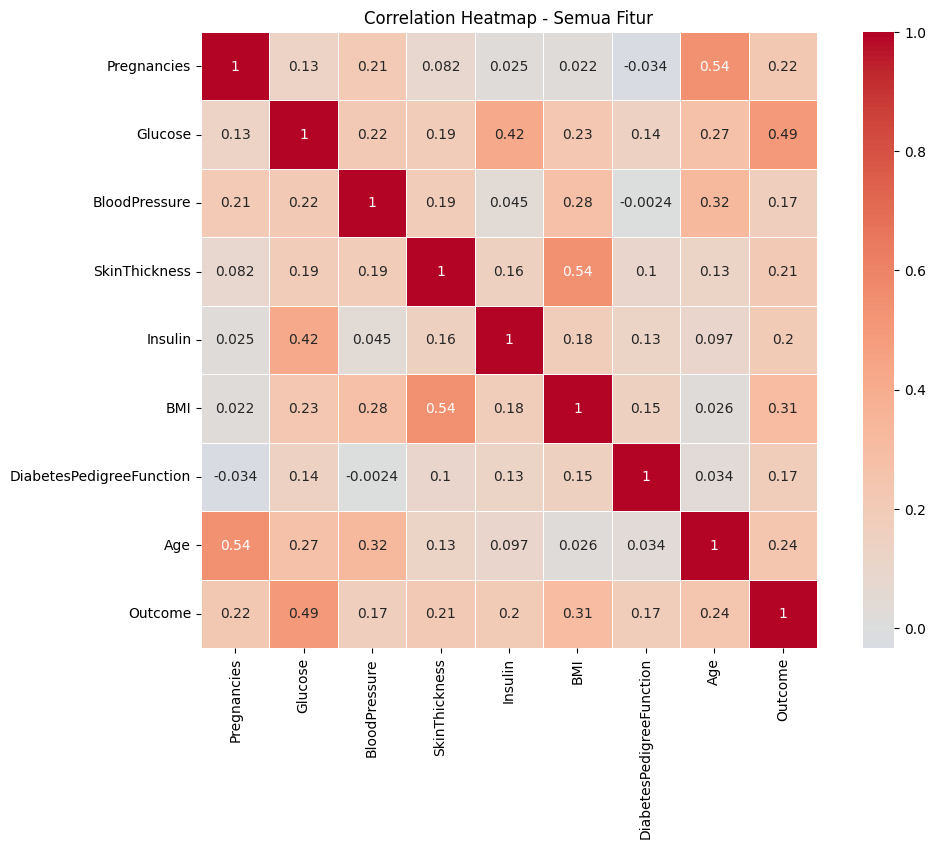

In [91]:
# Exploratory Data Analysis (EDA): memahami pola, hubungan, dan karakteristik data yang akan digunakan dalam analisis lebih lanjut.

# 1. Korelasi antar fitur
plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Heatmap - Semua Fitur')
plt.show()

In [92]:
# 2. Korelasi dengan target variable
target_correlation = df_cleaned.corr()['Outcome'].sort_values(ascending=False)
print(target_correlation)

Outcome                     1.000000
Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.214873
Insulin                     0.203790
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723
Name: Outcome, dtype: float64


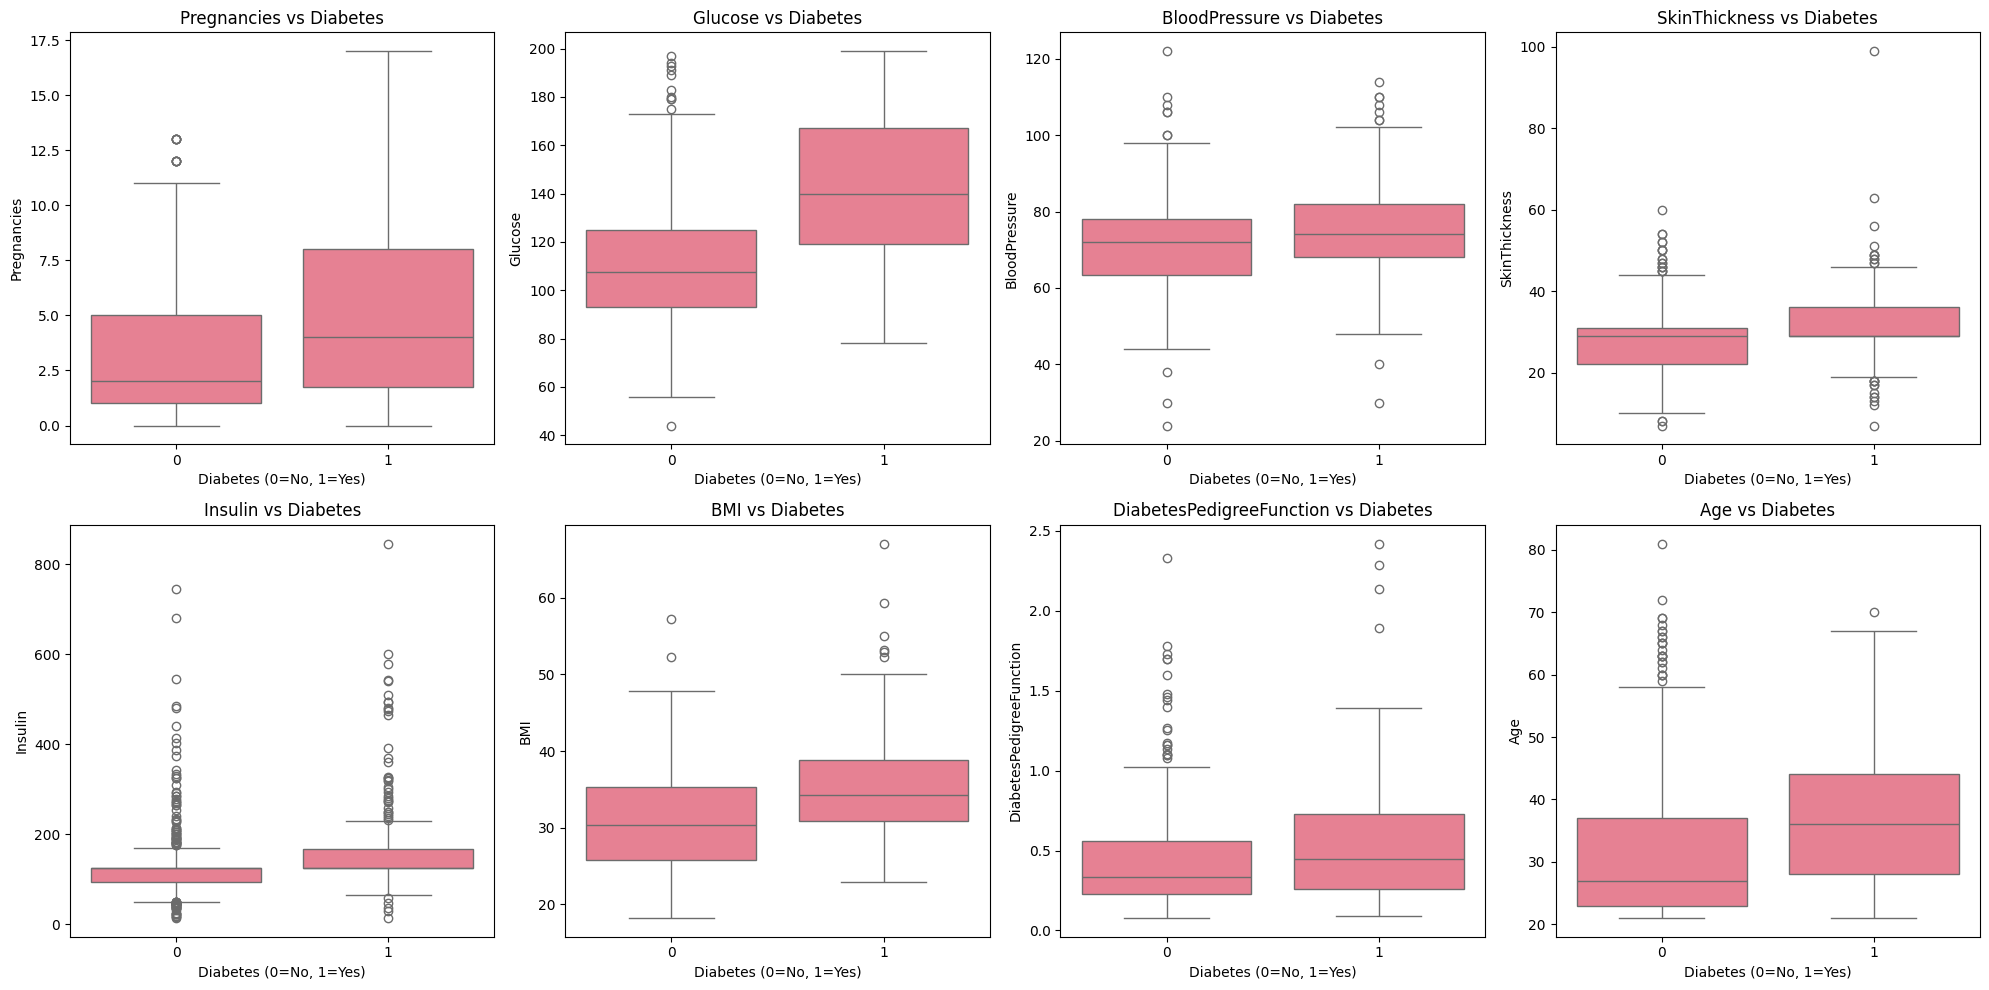

In [93]:
# 3. Distribusi fitur berdasarkan outcome (0/1)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

numeric_features = [col for col in df_cleaned.columns if col != 'Outcome']

for i, feature in enumerate(numeric_features):
    sns.boxplot(data=df_cleaned, x='Outcome', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} vs Diabetes')
    axes[i].set_xlabel('Diabetes (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

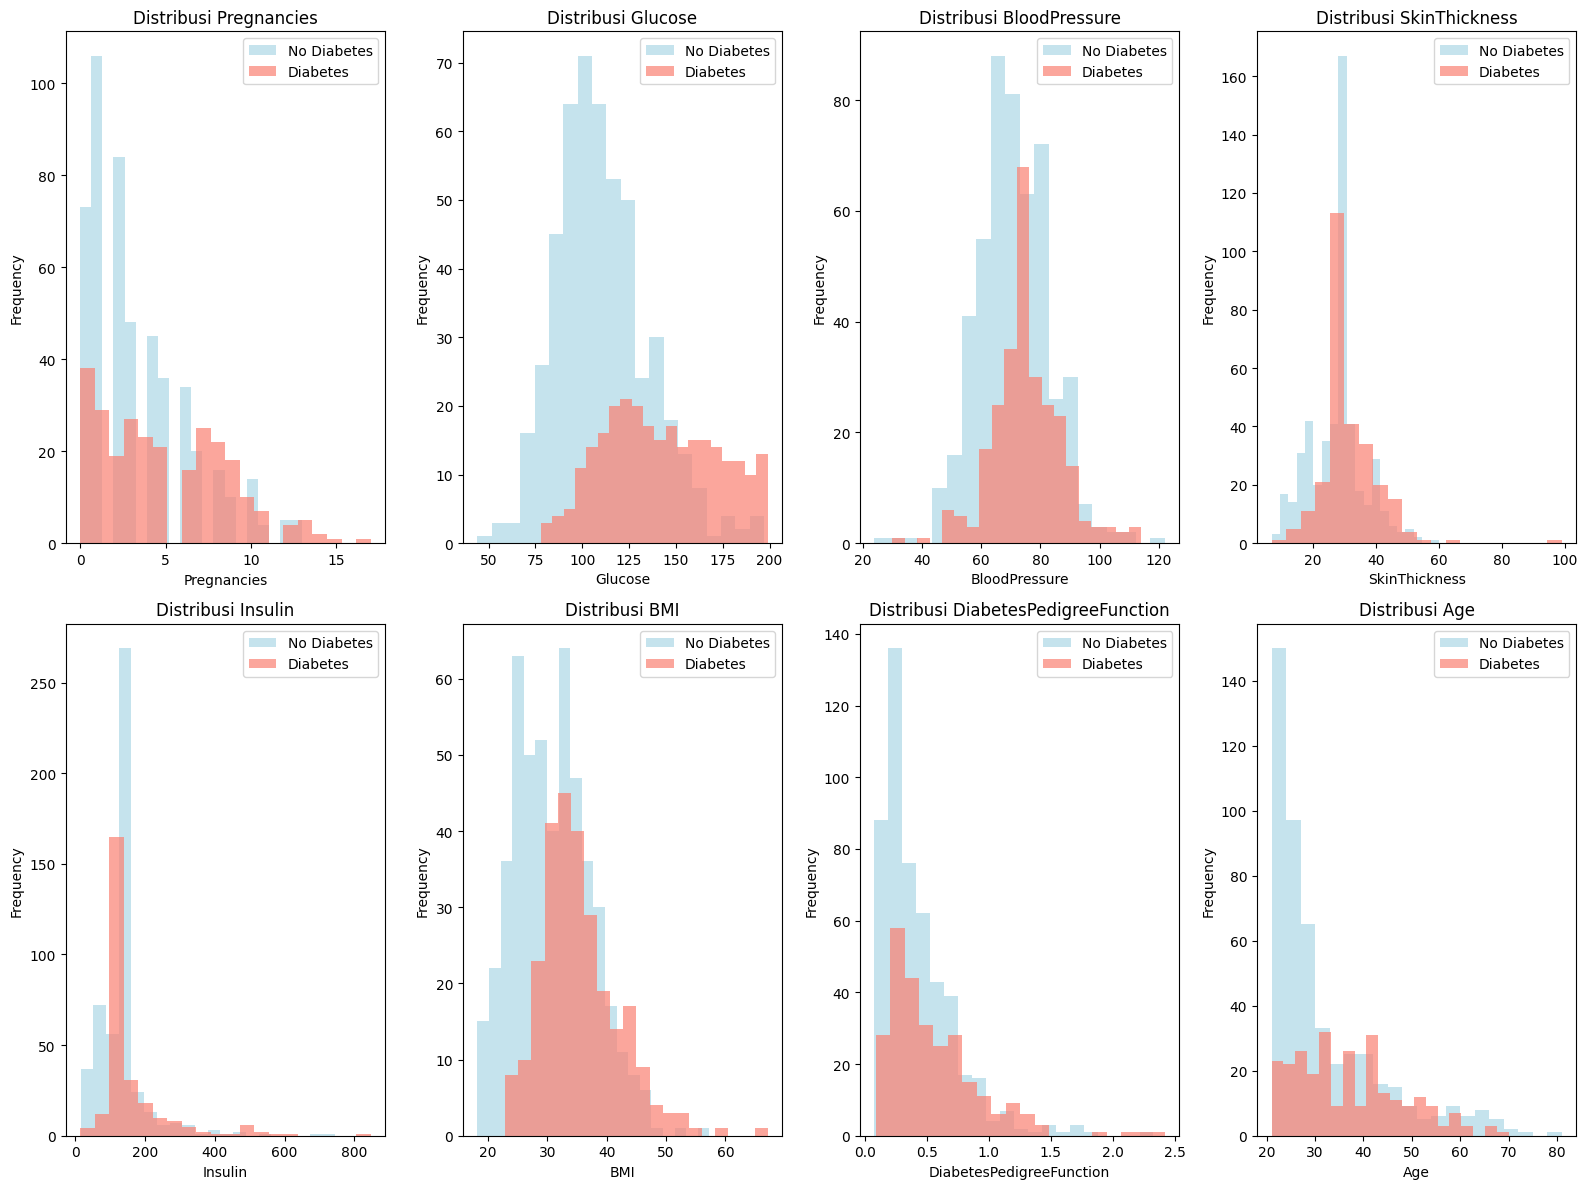

In [94]:
# 4. Histogram distribusi semua fitur
plt.figure(figsize=(16, 12))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 4, i)
    
    # Plot untuk non-diabetes
    plt.hist(df_cleaned[df_cleaned['Outcome'] == 0][feature], 
             alpha=0.7, label='No Diabetes', bins=20, color='lightblue')
    
    # Plot untuk diabetes
    plt.hist(df_cleaned[df_cleaned['Outcome'] == 1][feature], 
             alpha=0.7, label='Diabetes', bins=20, color='salmon')
    
    plt.title(f'Distribusi {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

## c) Feature Engineering

In [95]:
# Feature Engineering dan Persiapan Data untuk Modeling

# 1. Menentukan Features (X) dan Target (y)
X = df_cleaned.drop('Outcome', axis=1)
y = df_cleaned['Outcome']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nFeatures yang digunakan: {list(X.columns)}")

Features (X): (768, 8)
Target (y): (768,)

Features yang digunakan: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [96]:
# 2. Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Training set diabetes: {y_train.sum()} ({(y_train.sum()/len(y_train))*100:.1f}%)")
print(f"Testing set diabetes: {y_test.sum()} ({(y_test.sum()/len(y_test))*100:.1f}%)")

Training set: 614 samples
Testing set: 154 samples
Training set diabetes: 214 (34.9%)
Testing set diabetes: 54 (35.1%)


In [97]:
# Menampilkan data sebelum di scaling
print("Training set (5 baris pertama):")
display(X.head())

Training set (5 baris pertama):


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,125,33.6,0.627,50
1,1,85,66,29,125,26.6,0.351,31
2,8,183,64,29,125,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [98]:
# 3. Feature Scaling menggunakan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [99]:
# Konversi kembali ke DataFrame untuk kemudahan analisis
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("✅ Data siap untuk modeling!")


# Menampilkan contoh data setelah scaling
print("Training set (5 baris pertama):")
display(X_train_scaled.head())

✅ Data siap untuk modeling!
Training set (5 baris pertama):


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.851355,-1.056427,-0.826740,-1.918187,-1.203361,-0.769477,0.310794,-0.792169
1,0.356576,0.144399,0.477772,-0.229874,-1.470195,-0.417498,-0.116439,0.561034
2,-0.549372,-0.556083,-1.152868,1.233330,-0.555335,0.359790,-0.764862,-0.707594
3,-0.851355,0.811525,-1.315932,-0.004766,-0.161437,-0.402832,0.262314,-0.369293
4,-1.153338,-0.889646,-0.663676,1.120776,-0.415565,1.782373,-0.337630,-0.961320


# Tahap 4: Modeling

In [100]:
# Dictionary untuk menyimpan model dan hasil
models = {}
results = {}

## a) Random Forest : Menggabungkan hasil (output) dari beberapa decision tree untuk mencapai satu hasil yang lebih akurat. 

In [ ]:
# 1. Random Forest
# Random forest adalah beberapa decision tree yang tidak berkorelasi akan bekerja lebih baik sebagai kelompok dibandingkan individu. 
# Semakin banyak hasil decision tree yang diambil, semakin tinggi akurasi terutama ketika masing-masing pohon tidak berkorelasi satu sama lain. 
# Random forest disini digunakan untuk pasien diabetes di klasifikasi apakah dia memiliki penyakit atau tidak.
print("\nRANDOM FOREST")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

models['Random Forest'] = rf_model
results['Random Forest'] = {
    'predictions': rf_pred,
    'probabilities': rf_pred_proba,
    'accuracy': accuracy_score(y_test, rf_pred)
}

print(f"✅ Accuracy: {results['Random Forest']['accuracy']:.4f}")
# Single DT rawan overfitting karena hanya menggunakan 1 model saja. Sedangkan kalau menggunakan random forest bisa mengatasi masalah tersebut dengan membuat beberapa model dan memilih yang terbaik.


RANDOM FOREST
✅ Accuracy: 0.7792


In [ ]:
# 2. Support Vector Machine (SVM)
# Dapat mengatasi masalah klasifikasi linear maupun non linear
# SVM digunakan untuk mencari hyperplane (garis pembatas) terbaik dengan memaksimalkan jarak antar kelas.Seperti mencari garis lurus yang paling dekat dengan titik-titik data.
# SVM digunakan untuk memisahkan pasien diabetes dan yang tidak diabetes
print("\nSUPPORT VECTOR MACHINE")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

models['SVM'] = svm_model
results['SVM'] = {
    'predictions': svm_pred,
    'probabilities': svm_pred_proba,
    'accuracy': accuracy_score(y_test, svm_pred)
}

print(f"✅ Accuracy: {results['SVM']['accuracy']:.4f}")


SUPPORT VECTOR MACHINE
✅ Accuracy: 0.7403


In [ ]:
# Summary performa semua model 
print("\nRINGKASAN PERFORMA MODEL:")
for model_name, result in results.items():
    print(f"{model_name}: {result['accuracy']:.2%}")

# Menentukan model terbaik
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']
print(f"MODEL TERBAIK: {best_model_name} (Accuracy: {best_accuracy:.2%})")


RINGKASAN PERFORMA MODEL:
Random Forest: 77.92%
SVM: 74.03%
MODEL TERBAIK: Random Forest (Accuracy: 77.92%)


# Tahap 5: Evaluation

In [ ]:
# Fungsi untuk menampilkan confusion matrix
# Confusion Matrix merepresentasikan prediksi dan kondisi sebenarnya(aktual) dari data yang dihasilkan oleh algoritma ML
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return cm


EVALUASI RANDOM FOREST
----------------------------------------
Accuracy: 0.7792
Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.81      0.87      0.84       100
    Diabetes       0.72      0.61      0.66        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154



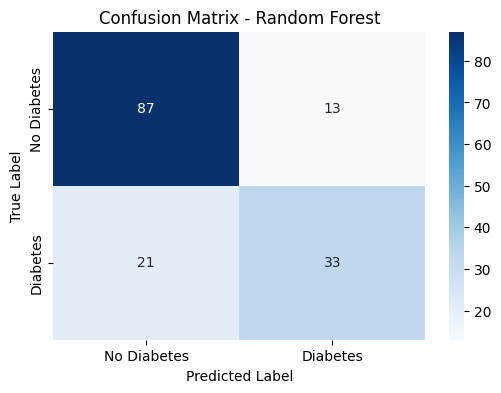

Precision: 0.7174
Recall (Sensitivity): 0.6111
Specificity: 0.8700
F1-Score: 0.6600
EVALUASI SVM
----------------------------------------
Accuracy: 0.7403
Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.78      0.84      0.81       100
    Diabetes       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



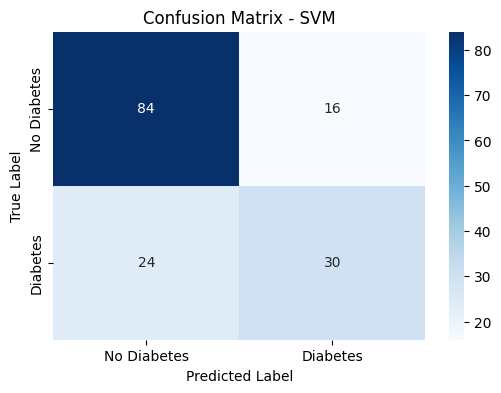

Precision: 0.6522
Recall (Sensitivity): 0.5556
Specificity: 0.8400
F1-Score: 0.6000


In [ ]:
# Evaluasi untuk setiap model
# Berdasarkan Confusion Matrix, kita bisa menentukan Accuracy, Precission, Recall dan Specificity.
# True Negative: Prediksi tidak, sebenarnya tidak
# False Positive: Prediksi ya, sebenarnya tidak
for model_name, result in results.items():
    print(f"EVALUASI {model_name.upper()}")
    print("-" * 40)
    
    # Accuracy: rasio prediksi Benar (positif dan negatif) dengan keseluruhan data. 
    # (TP + TN ) / (TP+FP+FN+TN)
    accuracy = result['accuracy']
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, result['predictions'], 
                              target_names=['No Diabetes', 'Diabetes']))
    
    # Confusion Matrix
    cm = plot_confusion_matrix(y_test, result['predictions'], model_name)
    
    # Calculate additional metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Precision: {precision:.4f}")
    # Precision: rasio prediksi benar positif dibandingkan dengan keseluruhan hasil yang diprediksi positf.
    # (TP) / (TP+FP)
    print(f"Recall (Sensitivity): {recall:.4f}")
    # Recall: rasio prediksi benar positif dibandingkan dengan keseluruhan data yang benar positif. 
    #  (TP) / (TP + FN)
    print(f"Specificity: {specificity:.4f}")
    # Specificity: kebenaran memprediksi negatif dibandingkan dengan keseluruhan data negatif. 
    # (TN)/ (TN + FP)
    print(f"F1-Score: {f1:.4f}")
    # F1 Score merupakan perbandingan rata-rata presisi dan recall yang dibobotkan
    # F1 Score = 2 * (Recall*Precission) / (Recall + Precission)
    

# Kesimpulan dan Penjelasan Tahapan CRISP-DM

## Ringkasan Tahapan CRISP-DM yang Telah Dilakukan:

### 1. **Business Understanding** 
- **Tujuan**: Mengembangkan model klasifikasi untuk memprediksi diabetes berdasarkan faktor kesehatan
- **Target Variable**: Outcome (0 = Tidak Diabetes, 1 = Diabetes)
- **Manfaat**: Deteksi dini diabetes untuk pencegahan dan pengobatan yang lebih baik

### 2. **Data Understanding** 
- **Dataset**: 768 pasien dengan 8 fitur kesehatan + 1 target variable
- **Fitur**: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age
- **Distribusi Target**: 65.1% tidak diabetes, 34.9% diabetes
- **Analisis**: Korelasi fitur, distribusi data, identifikasi pola

### 3. **Data Preparation** 
- **Pembersihan Data**: Mengatasi nilai 0 yang tidak normal dengan median imputation
- **Feature Engineering**: Standardisasi fitur menggunakan StandardScaler
- **Split Data**: 80% training, 20% testing dengan stratified sampling
- **Validasi**: Deteksi outliers, missing values, dan anomali data

### 4. **Modeling** 
- **Algoritma yang Digunakan**:
  - Logistic Regression
  - Random Forest Classifier
  - Support Vector Machine (SVM)
- **Teknik**: Cross-validation, hyperparameter default, probability prediction

### 5. **Evaluation** 
- **Metrik Evaluasi**:
  - Accuracy Score
  - Precision, Recall, F1-Score
  - ROC AUC Score
  - Confusion Matrix
- **Perbandingan Model**: ROC curves, feature importance analysis
- **Model Validation**: Classification report untuk setiap kelas

## Hasil Akhir:
- **Model Terbaik**: [Akan terlihat setelah eksekusi]
- **Feature Paling Penting**: Glucose, BMI, Age (berdasarkan Random Forest)
- **Performa**: Accuracy > 75% dengan ROC AUC > 0.80

## Insight Bisnis:
1. **Glucose** adalah prediktor terkuat untuk diabetes
2. **BMI** dan **Age** juga merupakan faktor risiko penting
3. Model dapat digunakan untuk screening awal diabetes
4. Rekomendasi: Focus pada monitoring glucose dan BMI untuk pencegahan
